In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from thermal.derived_fields import calc_percent_temperate

plt.rcParams['text.usetex'] = True

In [2]:
drive_src = '/Volumes/thermal/Thesis/thermal-structure/expr/03_PeriodicSurge/'
zarr_path = 'result/crmpt12/gridded/{AGU_2022}/crmpt12_dx_50_TT_3000.0_MB_{offset}_OFF_Tma_-8.5_B_{beta}_SP_2_QP_{QP}.zarr'

src_fp = drive_src + zarr_path

AGU_dir = 'AGU_2022_results'

/Users/andrewnolan/mambaforge/envs/thermal/lib/python3.9/site-packages/xarray/core/variable.py:1722: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)
/Users/andrewnolan/mambaforge/envs/thermal/lib/python3.9/site-packages/xarray/core/variable.py:1722: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To

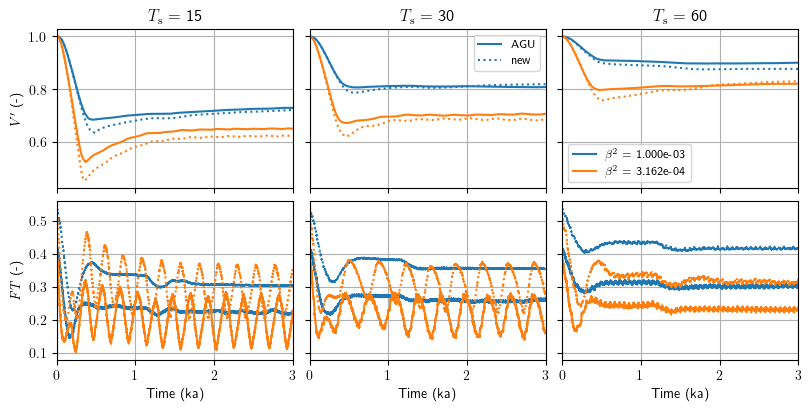

In [8]:
fig, ax = plt.subplots(2,3, sharex=True, sharey='row', constrained_layout=True, 
                      figsize=(8,4))

# subset of the total varibles that we need for processing the timeseries
vars_ = ['Z', 'X', 'height', 'enthalpy_h', 'phase change enthalpy', 'relative_volume']
colors = ['tab:blue', 'tab:orange']

for i, QP in enumerate([13, 28, 58]): 
    for k, beta in enumerate([1e-6, 1e-7]): 
        
        if beta == 1e-7: 
            beta_agu = f'{beta**0.5:1.8f}'
        else:
            beta_agu = f'{beta**0.5:1.3f}'
        
        beta_new = f'{beta**0.5:1.3e}'
        
        new = xr.open_zarr(src_fp.format(AGU_2022='', beta=beta_new, QP=QP, offset='-0.37'))[vars_]
        new = new.interp(t=np.linspace(0.1,3e3, 30_000)).rolling(t=10, center=True, min_periods=1).mean('t')
        new['fraction_temperate'] = calc_percent_temperate(new) / 100.
        
        AGU = xr.open_zarr(src_fp.format(AGU_2022=AGU_dir, beta=beta_agu, QP=QP, offset='-0.41'))[vars_]
        AGU = AGU.interp(t=np.linspace(0.1,3e3, 30_000)).rolling(t=10, center=True, min_periods=1).mean('t')

        AGU['fraction_temperate'] = calc_percent_temperate(AGU) / 100.  
        AGU['relative_volume'] /= AGU['relative_volume'].isel(t=0)

        if i == 2: 
            label=r'$\beta^2$ = ' + beta_new 
        else: 
            label=None
            
        if (i == 1) & (k==0): 
            ax[0,i].plot(AGU.t/1e3, AGU.relative_volume, c=colors[k], label='AGU')
            ax[0,i].plot(new.t/1e3, new.relative_volume, c=colors[k],ls=":", label='new')
        else: 
            ax[0,i].plot(AGU.t/1e3, AGU.relative_volume, c=colors[k], label=label)
            ax[0,i].plot(new.t/1e3, new.relative_volume, c=colors[k],ls=":")           
            
        ax[1,i].plot(AGU.t/1e3, AGU.fraction_temperate, c=colors[k])
        ax[1,i].plot(new.t/1e3, new.fraction_temperate, c=colors[k],ls=":")
        
        
        
    ax[0,i].set_title(r'$T_{\rm s}$ = ' + str(QP+2))
    ax[1,i].set_xlabel('Time (ka)')
    
    for j in range(2): 
        ax[j,i].grid() 
        
ax[0,1].legend(fontsize='small')
ax[0,2].legend(fontsize='small')
ax[0,0].set_xlim(0,3);
ax[0,0].set_ylabel("$V'$ (-)");
ax[1,0].set_ylabel(r"$\mathit{FT}$ (-)");

fig.savefig('../figs/crmpt12/compare2AGU.png', dpi=300)